# Residue Network Construction

In [1]:
from prody import *
import numpy as np
from os.path import basename
import fnmatch
import os
import networkx as nx
from networkx.algorithms import community
import itertools
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import stats

### Parse pdb file and select C<sub>$\beta$</sub> (C<sub>$\alpha$</sub> for Gly)

In [2]:
pdb_name = "5heb_eq.pdb"
structure_beta = parsePDB(pdb_name).select("(name CB and protein) or (name CA and resname GLY)")
file_name_wh_ex = str(os.path.splitext(pdb_name)[0])

@> 1902 atoms and 1 coordinate set(s) were parsed in 0.02s.


### Construct network by using a cut-off, please locate the cut-off.

In [3]:
betas_gly_alphas = structure_beta
betas_gly_alphas_coords = structure_beta.getCoords()
nodes = betas_gly_alphas
nodes_range = len(nodes)
nodes_list = nodes.getResnums()
#Contruct the network, please locate the cut-off value
ia_list = []
for i in range(nodes_range-1):
    for j in range(i+1, nodes_range):
        dist = calcDistance(betas_gly_alphas_coords[i], betas_gly_alphas_coords[j])
        if dist > 6.7:
            continue
        ia_list.append((nodes[i].getResnum(), nodes[j].getResnum()))

protein_graph = nx.Graph()
protein_graph.add_nodes_from(nodes_list)
protein_graph.add_edges_from(ia_list)
print(nx.info(protein_graph))

Name: 
Type: Graph
Number of nodes: 125
Number of edges: 369
Average degree:   5.9040


### Calculate number of neighbours (<em>k</em>) for each residue and visualize

In [4]:
neig_per_res = np.zeros((nodes_range))
for i in range(nodes_range):
    neig_per_res[i] = len(list(protein_graph.neighbors(nodes_list[i])))

np.savetxt(file_name_wh_ex+"_k_per_res.dat", neig_per_res, fmt='%1d')

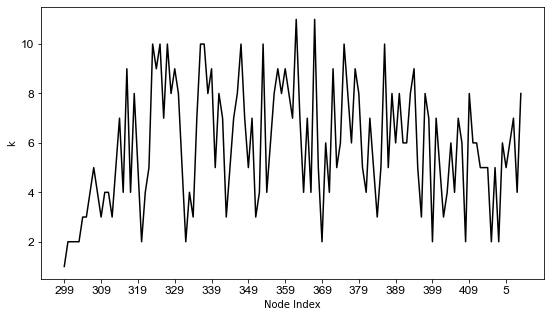

In [5]:
fig, ax = plt.subplots(figsize=(9,5))
ax.set_ylabel('k'); #set label names
ax.set_xlabel('Node Index');
plt.yticks(fontsize=12, fontname = "Arial")
plt.xticks(fontsize=12, fontname = "Arial")
plt.xticks(np.arange(0,nodes_range,10), nodes_list[0:-1:10])
plt.plot(neig_per_res, color='black')
plt.show()
plt.close()

### Calculate clustering coefficient (<em>C</em>) for each residue and visualize

In [6]:
clust_per_res = np.zeros((nodes_range))
clust_dict = nx.clustering(protein_graph)
for i in range(nodes_range):
    clust_per_res[i] = clust_dict[nodes_list[i]]

np.savetxt(file_name_wh_ex+"_clust_per_res.dat", clust_per_res, fmt='%1.3f')

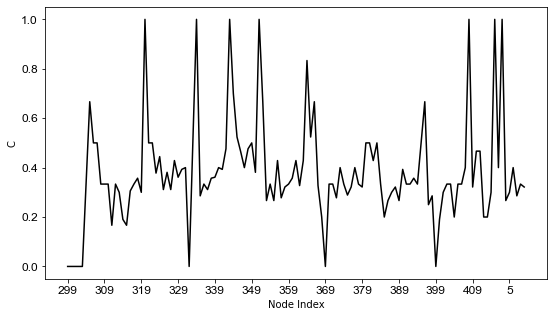

In [7]:
fig, ax = plt.subplots(figsize=(9,5))
ax.set_ylabel('C'); #set label names
ax.set_xlabel('Node Index');
plt.yticks(fontsize=12, fontname = "Arial")
plt.xticks(fontsize=12, fontname = "Arial")
plt.xticks(np.arange(0,nodes_range,10), nodes_list[0:-1:10])
plt.plot(clust_per_res, color='black')
plt.show()
plt.close()

### Calculate average shorthest path length (<em>\<L\></em>) for each residue and visualize

In [8]:
avg_path_L_all = dict(nx.all_pairs_shortest_path_length(protein_graph))
L_per_res = np.zeros((nodes_range))
L_pair_matrix = np.zeros((nodes_range, nodes_range))

In [9]:
for i in range(nodes_range):
    L_per_res[i] = np.mean(list(avg_path_L_all[nodes_list[i]].values()))

In [10]:
L_pair_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
for pair in itertools.permutations(list(range(nodes_range)), 2):
    L_pair_matrix[pair[0], pair[1]] = avg_path_L_all[nodes_list[pair[0]]][nodes_list[pair[1]]]

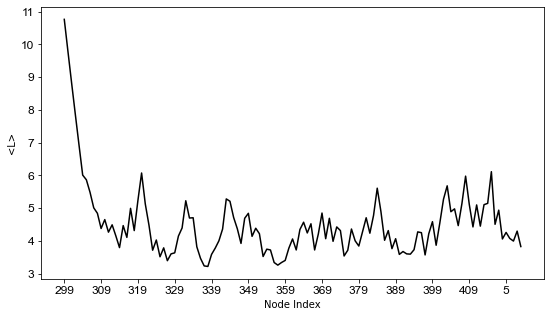

In [12]:
np.savetxt(file_name_wh_ex+"_L_per_res.dat", L_per_res, fmt='%1.3f')
fig, ax = plt.subplots(figsize=(9,5))
ax.set_ylabel('<L>'); #set label names
ax.set_xlabel('Node Index');
plt.yticks(fontsize=12, fontname = "Arial")
plt.xticks(fontsize=12, fontname = "Arial")
plt.xticks(np.arange(0,nodes_range,10), nodes_list[0:-1:10])
plt.plot(L_per_res, color='black')
plt.show()
plt.close()

### Now we will do GNM and construct Kirchhoff ( <strong>$\Gamma$</strong>)

### By taking the inverse and diagonal of $\Gamma$, we can calculate residue fluctuations.

In [13]:
gnm = GNM("")
gnm.buildKirchhoff(structure_beta, cutoff=6.7, gamma=1.0)
gnm.calcModes(100000000)
fluctus = np.diag(np.linalg.pinv(gnm.getKirchhoff()))
np.savetxt(file_name_wh_ex+"_fluctus_per_res.dat", fluctus, fmt='%1.3f')

@> Kirchhoff was built in 0.00s.
@> 124 modes were calculated in 0.02s.


### Visualize $\Gamma$<sup>-1</sup> as a heatmap.

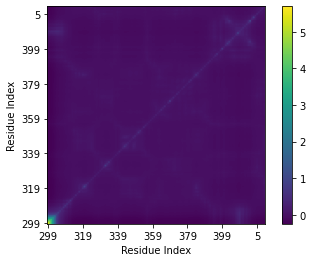

In [14]:
plt.imshow(np.linalg.pinv(gnm.getKirchhoff()), origin='lower')
plt.ylabel('Residue Index'); #set label names
plt.xlabel('Residue Index');
plt.xticks(np.arange(0,nodes_range,20), nodes_list[0:-1:20])
plt.yticks(np.arange(0,nodes_range,20), nodes_list[0:-1:20])
cbar = plt.colorbar()
plt.show()
plt.close()

### Visualize residue fluctuations

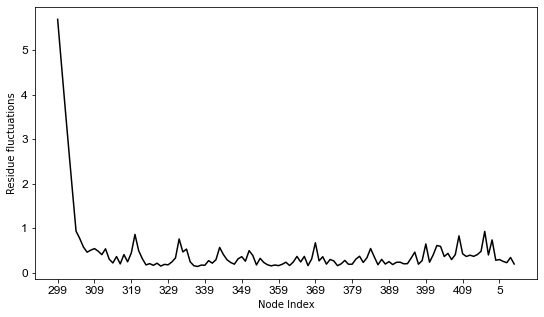

In [15]:
fig, ax = plt.subplots(figsize=(9,5))
ax.set_ylabel('Residue fluctuations'); #set label names
ax.set_xlabel('Node Index');
plt.yticks(fontsize=12, fontname = "Arial")
plt.xticks(fontsize=12, fontname = "Arial")
plt.xticks(np.arange(0,nodes_range,10), nodes_list[0:-1:10])
plt.plot(fluctus, color='black')
plt.show()
plt.close()

### Let's compare residue fluctuations and 1/k
For better comparison, values are normalized by their sums.

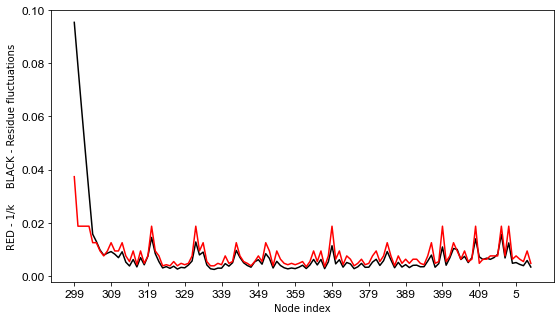



Pearson's R between residue fluctuations and 1/k:
0.77


In [16]:
fig, ax = plt.subplots(figsize=(9,5))
ax.set_ylabel('RED - 1/k     BLACK - Residue fluctuations'); #set label names
ax.set_xlabel('Node index');
plt.yticks(fontsize=12, fontname = "Arial")
plt.xticks(fontsize=12, fontname = "Arial")
plt.plot(np.divide(fluctus, np.sum(fluctus)), color='black')
plt.plot(np.divide(np.power(neig_per_res, -1), np.sum(np.power(neig_per_res, -1))), color='red')
plt.xticks(np.arange(0,nodes_range,10), nodes_list[0:-1:10])
plt.show()
plt.close()
print("\n")
print("Pearson's R between residue fluctuations and 1/k:")
print("{:.2f}".format(stats.pearsonr(fluctus,np.power(neig_per_res, -1))[0]))

### Let's compare residue fluctuations and <em>\<L\></em>

For better comparison, values are normalized by their sums.

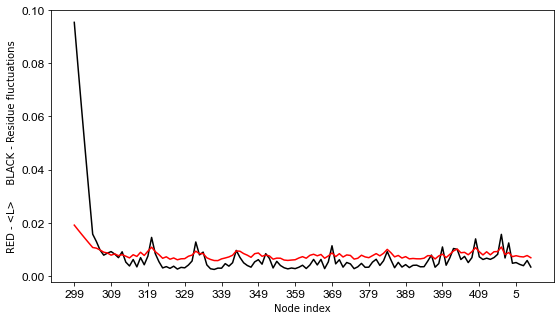



Pearson's R between residue fluctuations and <L>:
0.91


In [17]:
fig, ax = plt.subplots(figsize=(9,5))
ax.set_ylabel('RED - <L>     BLACK - Residue fluctuations'); #set label names
ax.set_xlabel('Node index');
plt.yticks(fontsize=12, fontname = "Arial")
plt.xticks(fontsize=12, fontname = "Arial")
plt.plot(np.divide(fluctus, np.sum(fluctus)), color='black')
plt.plot(np.divide(L_per_res, np.sum(L_per_res)), color='red')
plt.xticks(np.arange(0,nodes_range,10), nodes_list[0:-1:10])
plt.show()
plt.close()
print("\n")
print("Pearson's R between residue fluctuations and <L>:")
print("{:.2f}".format(stats.pearsonr(fluctus,L_per_res)[0]))

### Visualize all pair-wise <em>L</em> as a heatmap

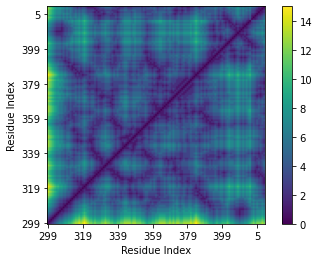

In [18]:
plt.imshow(L_pair_matrix, origin='lower')
plt.ylabel('Residue Index'); #set label names
plt.xlabel('Residue Index');
plt.xticks(np.arange(0,nodes_range,20), nodes_list[0:-1:20])
plt.yticks(np.arange(0,nodes_range,20), nodes_list[0:-1:20])
cbar = plt.colorbar()
plt.show()
plt.close()

### Let's select two residues (nodes), then compute all shorest paths between them

In [19]:
source = 310
target = 7

paths_btw_sel_pairs = list(nx.all_shortest_paths(protein_graph, source=source, target=target))
print("There are {:d} equivalent shortest paths,\neach of {:d} steps between residues {:d} and {:d}:\n"
      .format(len(paths_btw_sel_pairs), len(paths_btw_sel_pairs[0])-1, source, target))
for i in paths_btw_sel_pairs:
    print(', '.join(map(str, i)))

There are 5 equivalent shortest paths,
each of 6 steps between residues 310 and 7:

310, 309, 392, 356, 337, 327, 7
310, 309, 392, 357, 337, 327, 7
310, 311, 391, 358, 337, 327, 7
310, 309, 392, 356, 338, 327, 7
310, 309, 392, 357, 338, 327, 7


### Write a vmd file to visualize these paths on protein structure
In vmd file, the representations of paths are off, so please turn them on.

In [20]:
f = open(file_name_wh_ex+"_color_btwn_"+str(source)+"_"+str(target)+".vmd", 'w')
f.write("""
display projection Orthographic
color Display Background 8
axes location Off
display depthcue off
\n
""")

f.write("mol new {}.pdb\n".format(str(file_name_wh_ex)))
f.write("mol modstyle 0 0 NewCartoon {0.300000 50.000000 4.100000 0}\n")
f.write("mol modcolor 0 0 ColorID 8\n")

for i in range(len(paths_btw_sel_pairs)):
    f.write("mol addrep 0\n")
    f.write("mol modselect {:d} 0 resid {} and ((name CB and protein) or (name CA and resname GLY))\n".format(i+1,' '.join(map(str, paths_btw_sel_pairs[i]))))
    f.write("mol modstyle {:d} 0 CPK {{5.200000 0.000000 50.000000 0.000000}}\n".format(i+1))
    f.write("mol modcolor {:d} 0 ColorID {:d}\n".format(i+1, i+1))
    f.write("mol showrep 0 {:d} 0\n".format(i+1))
f.write("mol showrep 0 1 1\n")
f.close()
